In [1]:
import torch
import numpy as np
import torch.nn as nn

In [2]:
DATASET_PATH = "../data"
CHECKPOINT_PATH = "../saved_models/T3"

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [3]:
import urllib.request
from urllib.error import HTTPError
import os
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial3/"

pretrained_files = ["FashionMNIST_elu.config", "FashionMNIST_elu.tar",
                    "FashionMNIST_leakyrelu.config", "FashionMNIST_leakyrelu.tar",
                    "FashionMNIST_relu.config", "FashionMNIST_relu.tar",
                    "FashionMNIST_sigmoid.config", "FashionMNIST_sigmoid.tar",
                    "FashionMNIST_swish.config", "FashionMNIST_swish.tar",
                    "FashionMNIST_tanh.config", "FashionMNIST_tanh.tar"]
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f'downloading..{file_url}')
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("something went wrong..{e}")

In [4]:
class ActivationFunction(nn.Module):
    def __init__(self):
        super().__init__() 
        self.name = self.__class__.__name__
        self.config = {"name":self.name}

In [5]:
class Sigmoid(ActivationFunction):
    def forward(self, x):
        return 1/(1+torch.exp(-x))

In [6]:
sig = Sigmoid()
sig.config, sig.name, sig.forward(torch.tensor(2))

({'name': 'Sigmoid'}, 'Sigmoid', tensor(0.8808))

In [7]:
class Tanh(ActivationFunction):
    def forward(self, x):
        exp, neg_exp = torch.exp(x), torch.exp(-x)
        return (exp-neg_exp)/(exp+neg_exp) 

In [8]:
class Relu(ActivationFunction):
    def forward(self, x):
        return x * (x>0).float()
relu = Relu()
relu.forward(torch.Tensor([20,1,-8]))

tensor([20.,  1., -0.])

In [9]:
class LeakyRelu(ActivationFunction):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config['alpha'] = alpha
    def forward(self, x):
        return torch.where(x > 0, x , x*self.config['alpha'])
    
lr = LeakyRelu()
lr.forward(torch.Tensor([20,1,-8]))

tensor([20.0000,  1.0000, -0.8000])

In [10]:
t = torch.Tensor([20,1,-8])

In [11]:
class ELU(ActivationFunction):
    def forward(self, x):
        return torch.where(x>0, x, torch.exp(x)-1)
elu = ELU()
elu.forward(t), elu(t)


(tensor([20.0000,  1.0000, -0.9997]), tensor([20.0000,  1.0000, -0.9997]))

In [12]:
class Swish(ActivationFunction):
    def forward(self, x):
        return x*torch.sigmoid(x)

In [13]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": Relu,   
    "leakyrelu": LeakyRelu,
    "elu": ELU,
    "swish": Swish
}

In [14]:
def get_grads(act_fn, x):
    x = x.clone().requires_grad_()
    out = act_fn(x)
    out.sum().backward()
    print(x.grad)
    return x.grad

In [15]:
get_grads(Swish(), t)

tensor([ 1.0000,  0.9277, -0.0023])


tensor([ 1.0000,  0.9277, -0.0023])

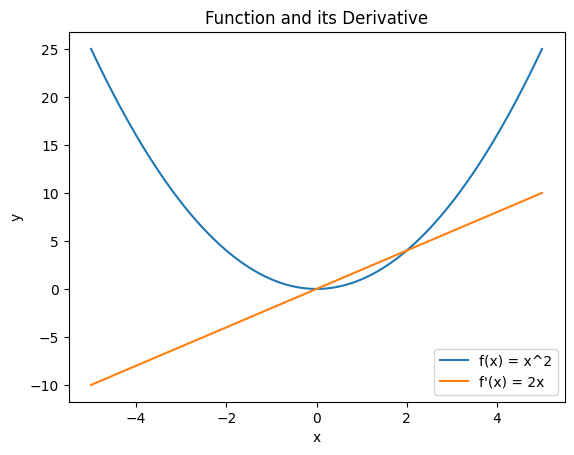

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Define the function and its derivative
def f(x):
    return x ** 2

def f_prime(x):
    return 2 * x

# Generate x values
x = np.linspace(-5, 5, 100)

# Calculate y values for the function and its derivative
y = f(x)
y_prime = f_prime(x)

# Create a figure and an axes object
fig, ax = plt.subplots()

# Plot the function and its derivative using the axes object
ax.plot(x, y, label="f(x) = x^2")
ax.plot(x, y_prime, label="f'(x) = 2x")

# Add a legend and titles
ax.legend()
ax.set_title("Function and its Derivative")
ax.set_xlabel("x")
ax.set_ylabel("y")

# Display the plot
plt.show()


In [17]:
def vis_act_fn(act_fn, ax, x):
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    
    